<a href="https://colab.research.google.com/github/CoAxLab/Data-Explorations/blob/main/book/exercises/resampling-methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 13:  Resampling methods

This homework assignment is designed to give you practice with bootstrapping and permutation tests.

You will need to download the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file from the *Homework/hcp_data* folder in the class GitHub repository. 

This data is a portion of the [Human Connectome Project database](http://www.humanconnectomeproject.org/). It provides measures of cognitive tasks and brain morphology measuresments from 1206 participants. The full description of each variable is provided in the **HCP_S1200_DataDictionary_April_20_2018.csv** file in the *Homework/hcp_data* folder in the class GitHub repository.

---
## 1. Loading & Visualizing the Data (1 point)

Use the `setwd` and `read.csv` functions to load data from the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file. 

(a) Using the tidyverse tools, make a new dataframe `d1` that only inclues the subject ID (`Subject`), gender (`Gender`, self reported at time of data collection), Flanker Task performance (`Flanker_Unadj`), total intracranial volume (`FS_IntraCranial_Vol`), total white matter volume (`FS_Tot_WM_Vol`), and total grey matter volume (`FS_Total_GM_Vol`) variables and remove all _na_ values.

Use the `head` function to look at the first few rows of each data frame. 

In [7]:
#setwd("C:/Users/MJ/Destop/data_science")
ds = read.csv("unrestricted_trimmed_1_7_2020_10_50_44.csv")

library(tidyverse)
d1 = na.omit(select(ds, Subject, Gender, Flanker_Unadj, FS_IntraCranial_Vol, FS_Tot_WM_Vol, FS_Total_GM_Vol))

head(d1)


,Subject,Gender,Flanker_Unadj,FS_IntraCranial_Vol,FS_Tot_WM_Vol,FS_Total_GM_Vol
,<int>,<chr>,<dbl>,<dbl>,<int>,<int>
2,100206,M,130.42,1864518,543134,807245
3,100307,F,112.56,1512540,407292,664124
4,100408,M,121.18,1684117,500417,726206
5,100610,M,126.53,1816044,512946,762308
6,101006,F,101.85,1437868,429449,579632
7,101107,M,107.04,1512727,416995,665024


(b) Plot grey matter volume (x axis) against intracranial volume (y axis) and Gender (point color). 

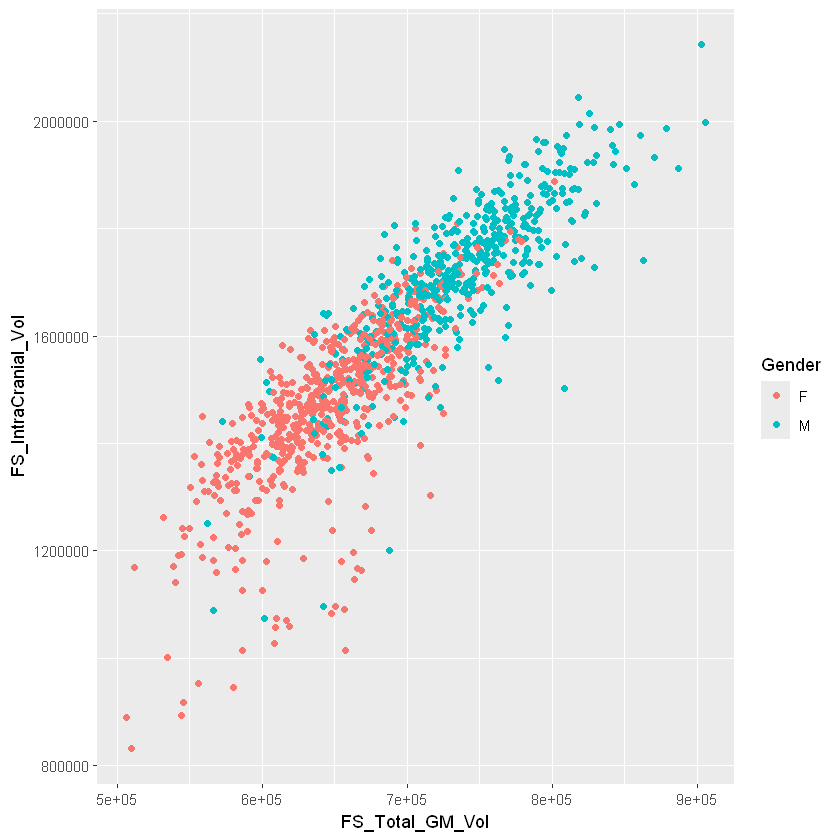

In [12]:
library(ggplot2)

ggplot(data = d1, mapping = aes(x = FS_Total_GM_Vol, y = FS_IntraCranial_Vol, color = Gender)) + geom_point()



What patterns do you observe in the scatter plot?

> There appears (solely based on the plot) to be a a general positive relationship between gray matter volume and intracranial volume. There also appears to be a main effect of gender such that althouogh the same trend (mentioned earlier) exists for both female and male participants, female participants appear to have lower gray matter and intracranial volume than male participants.
> 

---
## 2. Logistic classifier (2 points)

We want to try predicting gender using the neural data you have loaded.

(a) Run a logisic regression model to predict gender from total white matter volume, total grey matter volume, and intracranial volume. 

In [26]:
d1$Gender = as.factor(d1$Gender)

mod1 = glm(Gender ~ FS_IntraCranial_Vol + FS_Tot_WM_Vol + FS_Total_GM_Vol, data = d1, family = "binomial")

summary(mod1)



Call:
glm(formula = Gender ~ FS_IntraCranial_Vol + FS_Tot_WM_Vol + 
    FS_Total_GM_Vol, family = "binomial", data = d1)

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -2.262e+01  1.347e+00 -16.787  < 2e-16 ***
FS_IntraCranial_Vol  5.020e-06  1.177e-06   4.263 2.01e-05 ***
FS_Tot_WM_Vol        2.140e-06  3.059e-06   0.699    0.484    
FS_Total_GM_Vol      1.959e-05  3.145e-06   6.229 4.70e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1534.13  on 1112  degrees of freedom
Residual deviance:  919.85  on 1109  degrees of freedom
AIC: 927.85

Number of Fisher Scoring iterations: 5


Which factors are signficantly associated with gender?

> Intracranial volume and gray amtter volume are significantly associated with gender.
> 

(b) Estimate the prediction accuracy of your model (Note: this is the training set accuracy). Set your prediction threshold to 0.5.

In [54]:
#d1$Gender
#tells us that F is the Gender = 0 value

pred = predict.glm(mod1, newdata = d1)
act = d1$Gender

og_acc = mean((ifelse(pred > 0.5, "M", "F")) == act) #save for later
og_acc

[1] 0.8104223

What is the prediction accuracy for gender from the full model?

> 81.04%
> 

---
## 3. Bootstrapped accuracy (3 points)

Use bootstrapping to estimate the confidence intervals of the _prediction accuracy_ of your model (i.e., the confidence of the correlation between $\hat{y}$ and $y$). Plot the histogram of the bootstrapped prediction accuracies and estimate the confidence intervals off of the standard deviation from the bootstrap.



ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = d1, statistic = acc, R = 1000)


Bootstrap Statistics :
     original        bias    std. error
t1* 0.8203055 -0.0001769991  0.01218788

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot_res, type = c("norm", "perc"))

Intervals : 
Level      Normal             Percentile     
95%   ( 0.7966,  0.8444 )   ( 0.7951,  0.8428 )  
Calculations and Intervals on Original Scale

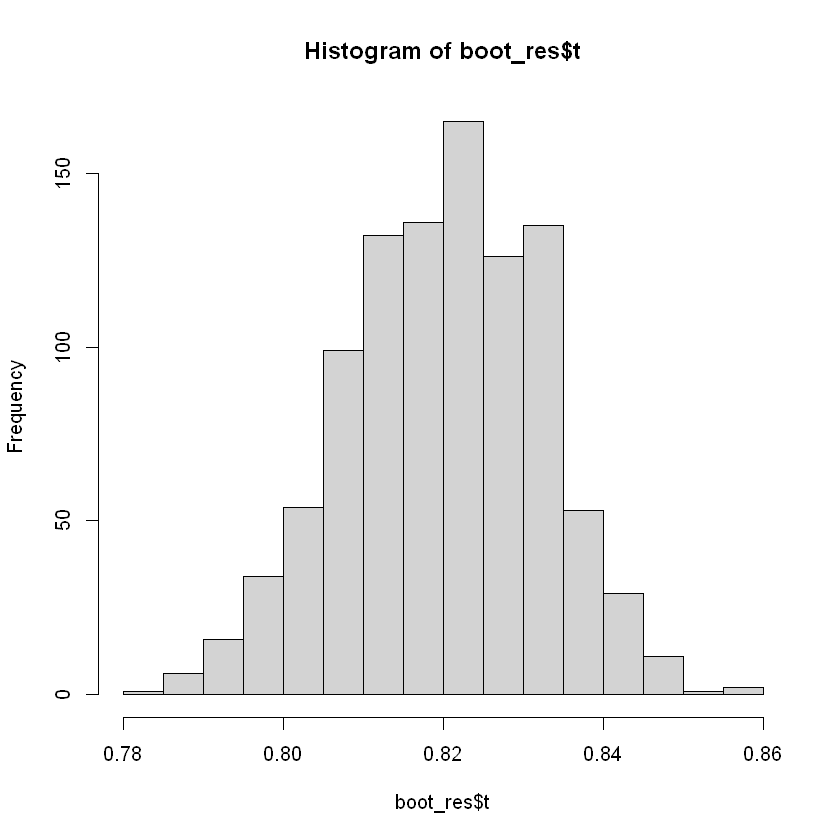

In [45]:
library(boot)

acc = function(d1, samp) {
  data = d1[samp, ]
  this_mod = glm(Gender ~ FS_IntraCranial_Vol + FS_Tot_WM_Vol + FS_Total_GM_Vol,data = data, family = "binomial")
  prob = predict(this_mod, type = "response")
  pred = ifelse(prob > 0.5, 1, 0)
  act = ifelse(data$Gender == "M", 1, 0)
  mean(pred == act)
}


boot_res = boot(data = d1, statistic = acc, R = 1000)

boot_res
#histogram
hist(boot_res$t, breaks = 20)
#CI
boot.ci(boot_res, type = c("norm", "perc"))

How robust is the prediction accuracy of the full model?

> The model appears to be decently robust. This is based on a decently high mean estimate (0.82), a confidence interval that does not contain 0.5 (0.80-0.84; since 0.5 is chance) and a gaussian-shaped curve. 

---
## 4. Permutation test for grey matter effects (3 points)

Now run a permutation test, with 1000 iterations, to evaluate how much grey matter volume contributes to the prediction accuracy. Compare the prediction accuracy of the full (unpermuted model) with the distribution of accuracies you get with a randomized grey matter volume term using a histogram (Hint: use the `abline` function to show the original accuracy on the histogram).

[1] 0.805345

[1] 0.037

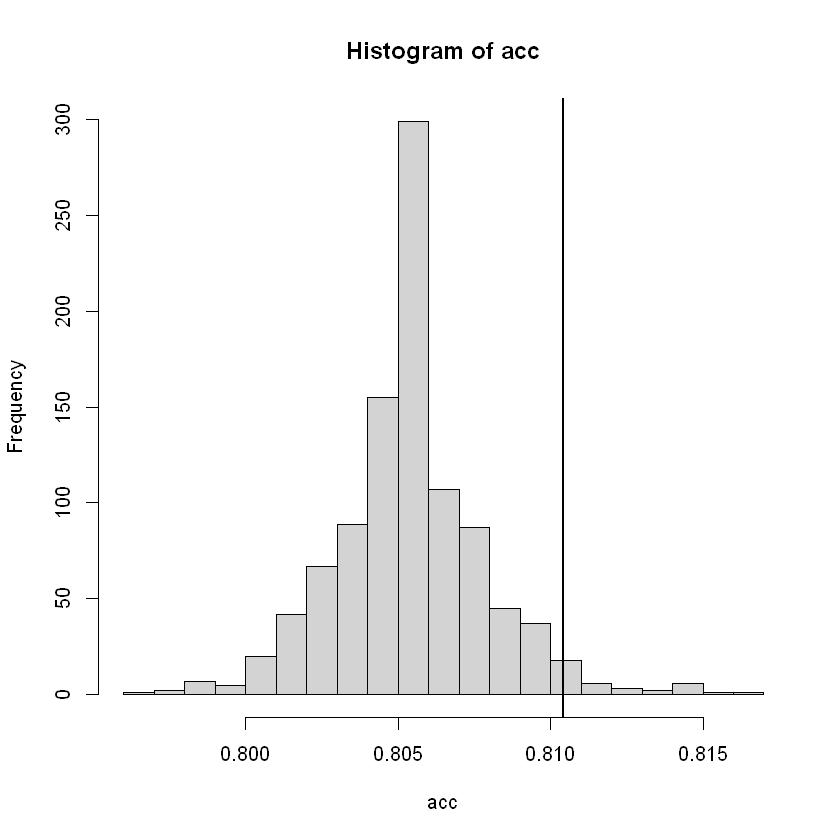

In [62]:
acc = rep(NA, times = 1000)

for (i in c(1:1000)) {
  # permutate
  dperm = d1
  dperm$FS_Total_GM_Vol = sample(dperm$FS_Total_GM_Vol)
  perm_model = glm(Gender ~ FS_IntraCranial_Vol + FS_Tot_WM_Vol + FS_Total_GM_Vol, data = dperm, family = "binomial") #new mod
  prob = predict(perm_model, type = "response")
  pred = ifelse(prob > 0.5, 1, 0) #assign based on 0.5
  act = ifelse(dperm$Gender == "M", 1, 0)
  acc[i] = mean(pred == act) #return and store accuracy
}


#hist
hist(acc, breaks = 20)
abline(v = og_acc, lwd = 2)

#extra p-value to check numerically
mean(acc)
p = mean(acc >= og_acc)
p

How much does the grey matter volume influence the prediction accuracy of the model?

> Gray matter volume appears to matter significantly (delta_acc = 81.04% - 80.53%, p = 0.037) - it is unlikely that the "true" mean accuracy would be from this generated data set.
> 

---
## 5. Reflection (1 point)

Differentiate the bootstrap from a permutation test. Describe each and when is it appropriate to each.

> Bootstrapping randomizes the order of rows while permutation randomizes the assignment of x to y. Bootstrapping is used to estimate variablility/confidence intervals while permutations are used to determine the significance of specific effects
> 

**DUE:** 5pm EST, March 27, 2024

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Someone's Name*